## A complete example of Exploratory Data Analysis (EDA)

we're using the **Employee Attrition** Dataset. It is good for this example because it is not so big, but it enables us to highlight several different situations with Data

https://objectstorage.us-ashburn-1.oraclecloud.com/n/bigdatadatasciencelarge/b/hosted-ds-datasets/o/synthetic%2Forcl_attrition.csv

We're developing this EDA because we want to develop a ML model to identify people at risk of leaving the company.
We will be using the column **Attrition** as target for our classifier

In [68]:
import pandas as pd
import numpy as np

import ads

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

%matplotlib inline

### Read the data and have a first look

In [4]:
# for the example, we will be using the Employe attrtition dataset. We can find a public version here
URL = "https://objectstorage.us-ashburn-1.oraclecloud.com/n/bigdatadatasciencelarge/b/hosted-ds-datasets/o/synthetic%2Forcl_attrition.csv"

df = pd.read_csv(URL)

df.head()

,Age,Attrition,TravelForWork,SalaryLevel,JobFunction,CommuteLength,EducationalLevel,EducationField,Directs,EmployeeNumber,...,WeeklyWorkedHours,StockOptionLevel,YearsinIndustry,TrainingTimesLastYear,WorkLifeBalance,YearsOnJob,YearsAtCurrentLevel,YearsSinceLastPromotion,YearsWithCurrManager,name
0,42,Yes,infrequent,5054,Product Management,2,L2,Life Sciences,1,1,...,80,0,8,0,1,6,4,0,5,Tracy Moore
1,50,No,often,1278,Software Developer,9,L1,Life Sciences,1,2,...,80,1,10,3,3,10,7,1,7,Andrew Hoover
2,38,Yes,infrequent,6296,Software Developer,3,L2,Other,1,4,...,80,0,7,3,3,0,0,0,0,Julie Bell
3,34,No,often,6384,Software Developer,4,L4,Life Sciences,1,5,...,80,0,8,3,3,8,7,3,0,Thomas Adams
4,28,No,infrequent,2710,Software Developer,3,L1,Medical,1,7,...,80,1,6,3,3,2,2,2,2,Johnathan Burnett


#### How many columns and their (initial) data types

In [5]:
df.columns

Index(['Age', 'Attrition', 'TravelForWork', 'SalaryLevel', 'JobFunction',
       'CommuteLength', 'EducationalLevel', 'EducationField', 'Directs',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'WeeklyWorkedHours', 'StockOptionLevel',
       'YearsinIndustry', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsOnJob', 'YearsAtCurrentLevel', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'name'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   TravelForWork             1470 non-null   object
 3   SalaryLevel               1470 non-null   int64 
 4   JobFunction               1470 non-null   object
 5   CommuteLength             1470 non-null   int64 
 6   EducationalLevel          1470 non-null   object
 7   EducationField            1470 non-null   object
 8   Directs                   1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [7]:
# when Pandas reads a CSV all string columns are identified and loaded as Object

### First observations:
* we have 1470 rows and 36 columns.
* several columns contains strings
* all the columns with numbers contains only integers (no float)

One important thing is to identify which columns should be treated as **Categorical**. Categorical are discrete features, with only a limited number of different values.

### Identify Categorical features

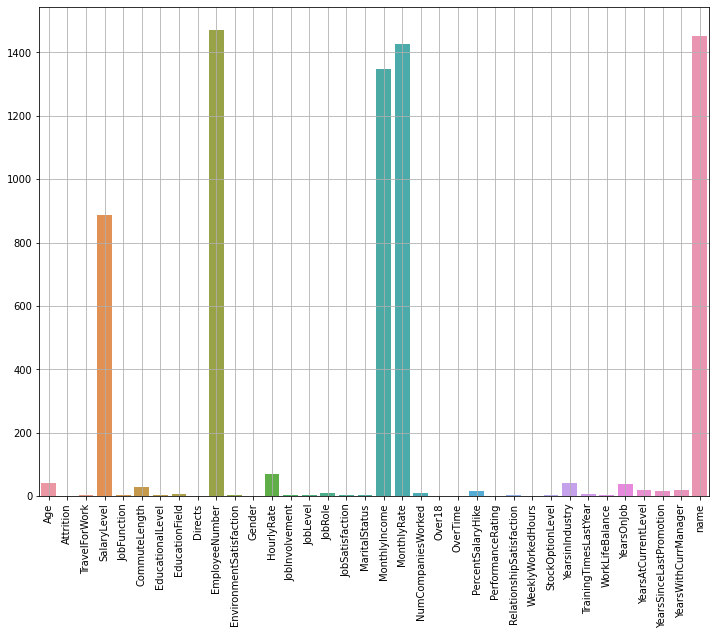

In [34]:
# one first indication comes from the number of different values

# let's do a plot
FIGSIZE = (12,9)

cols = df.columns

list_count =[df[col].nunique() for col in cols]

# using Seaborn
plt.figure(figsize=FIGSIZE)
sns.barplot(x=cols, y=list_count)
plt.xticks(rotation=90)
plt.grid(True)

Employee number and name have, obviously, all different values. But these two columns won't be really useful to develop a ML model

Interesting thing:
* MonthlyIncome and MonthlyRate have all different values. For this reason, better to treat them as continuous
* Also SalaryLevel has a lot of different values

Well, it makes sense.

In [13]:
# let's do a deep dive on the other. Consider only cols with less than 100 values

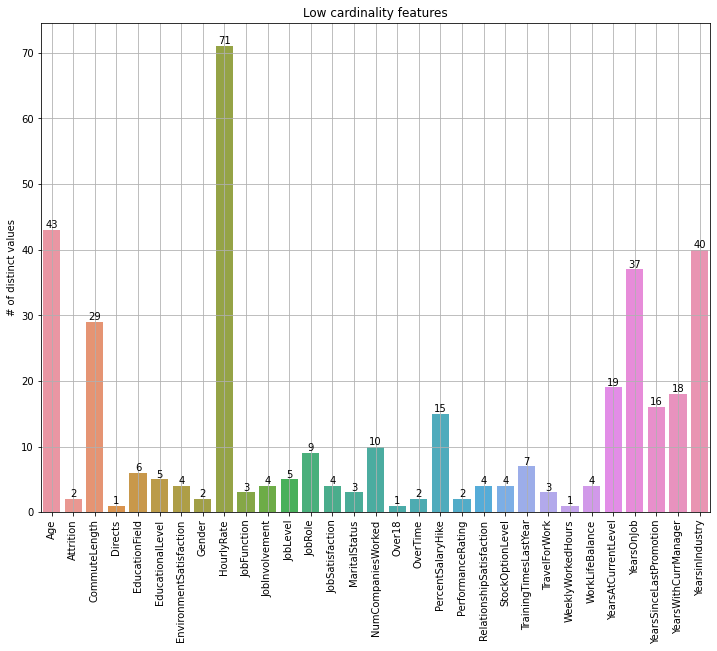

In [37]:
# give a better look at cols with low cardinality
THR = 100

# to get cols in alfabetical order
cols = sorted(df.columns)

# changed using list comprehension, to shorten code
cols2 = [col for col in cols if df[col].nunique() < THR]
list_count2 = [df[col].nunique() for col in cols if df[col].nunique() < THR]

# plot
plt.figure(figsize=FIGSIZE)
plt.title('Low cardinality features')
ax = sns.barplot(x=cols2, y=list_count2)
# to plot values on bar
ax.bar_label(ax.containers[0])
plt.xticks(rotation=90)
plt.ylabel('# of distinct values')
plt.grid(True)

### Split in categorical and numerical

* we have three columns (Directs, Over18, WeeklyWorkedHours) with only one values. Constants as useless for ML
* all the other columns have few distinct values and therefore can be considered as categorical

so we can say: if num_distinct < 100 it is categorical

In [32]:
THR = 100

cols_to_drop = sorted([col for col in df.columns if df[col].nunique() == 1 or (col in ['EmployeeNumber', 'name'])])
cat_cols = sorted([col for col in df.columns if (df[col].nunique() < THR) and (df[col].nunique() > 1)])

# remaining are numerical
num_cols = sorted(list(set(df.columns) - set(cat_cols) - set(cols_to_drop)))

print('All columns:', len(df.columns))
print()
print('Categorical columns (', len(cat_cols), '):', cat_cols)
print()
print('Numerical columns(', len(num_cols), '):', num_cols)
print()
print('Columns dropped(', len(cols_to_drop), '):', cols_to_drop)
print()

All columns: 36

Categorical columns ( 28 ): ['Age', 'Attrition', 'CommuteLength', 'EducationField', 'EducationalLevel', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobFunction', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TrainingTimesLastYear', 'TravelForWork', 'WorkLifeBalance', 'YearsAtCurrentLevel', 'YearsOnJob', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'YearsinIndustry']

Numerical columns( 3 ): ['MonthlyIncome', 'MonthlyRate', 'SalaryLevel']

Columns dropped( 5 ): ['Directs', 'EmployeeNumber', 'Over18', 'WeeklyWorkedHours', 'name']



### Plot histograms of Categorical columns to get distribution of values

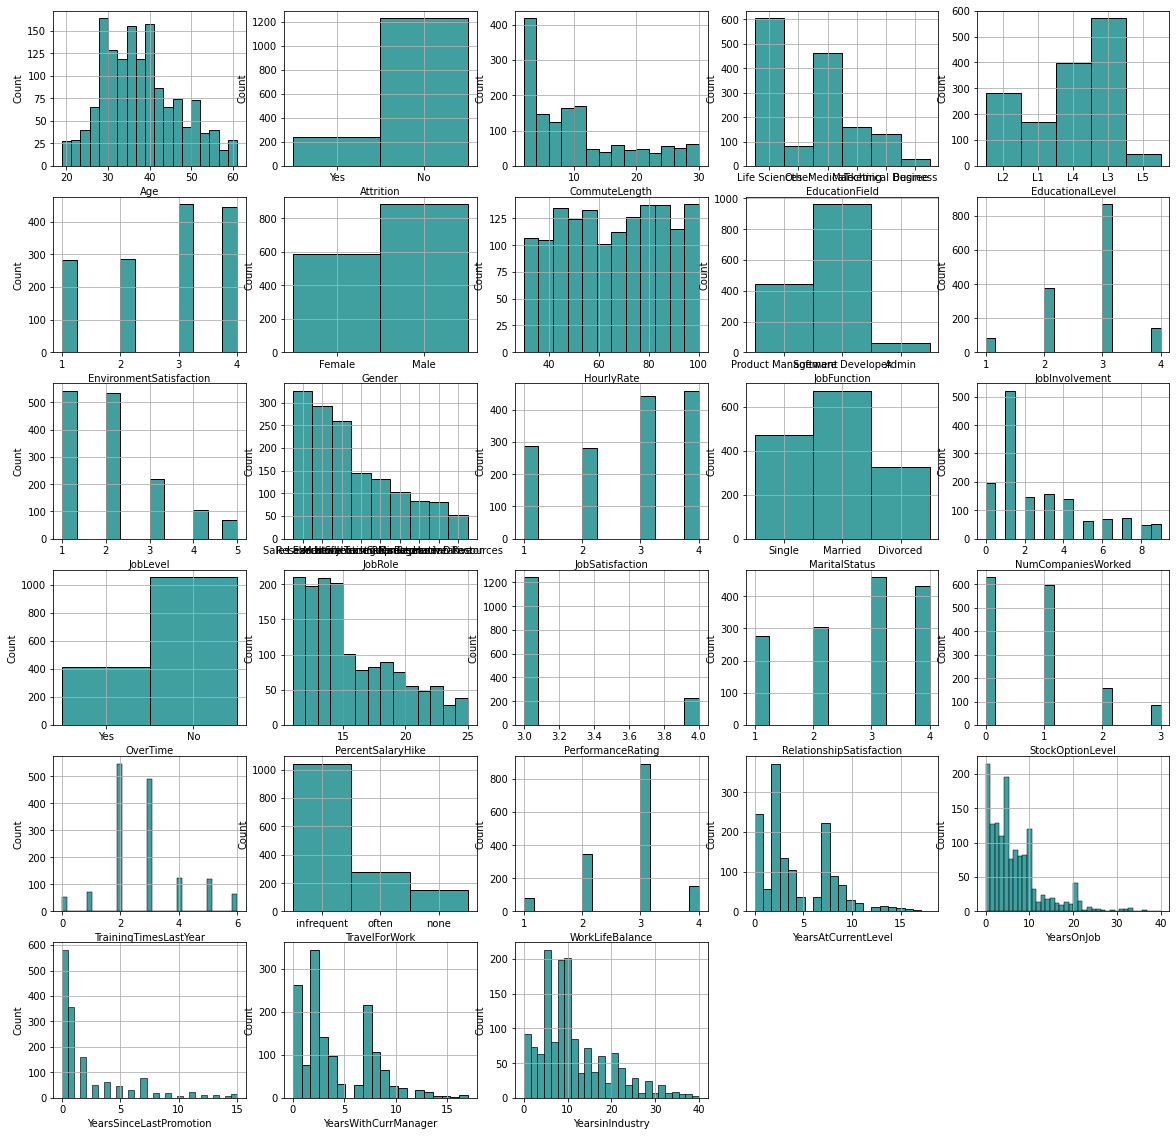

In [39]:
# need to change to get the best size for visualization
FIGSIZE = (20,20)

NROWS = 6
NCOLS = 5

plt.figure(figsize=FIGSIZE)

#
# here we do a loop over all columns and use subplot to arrange in a grid of plots
#
for i, col in enumerate(cat_cols):
    plt.subplot(NROWS, NCOLS, i+1)
    # using Seaborn
    sns.histplot(data=df[col])
    plt.grid(True)
plt.show()

### Numerical columns

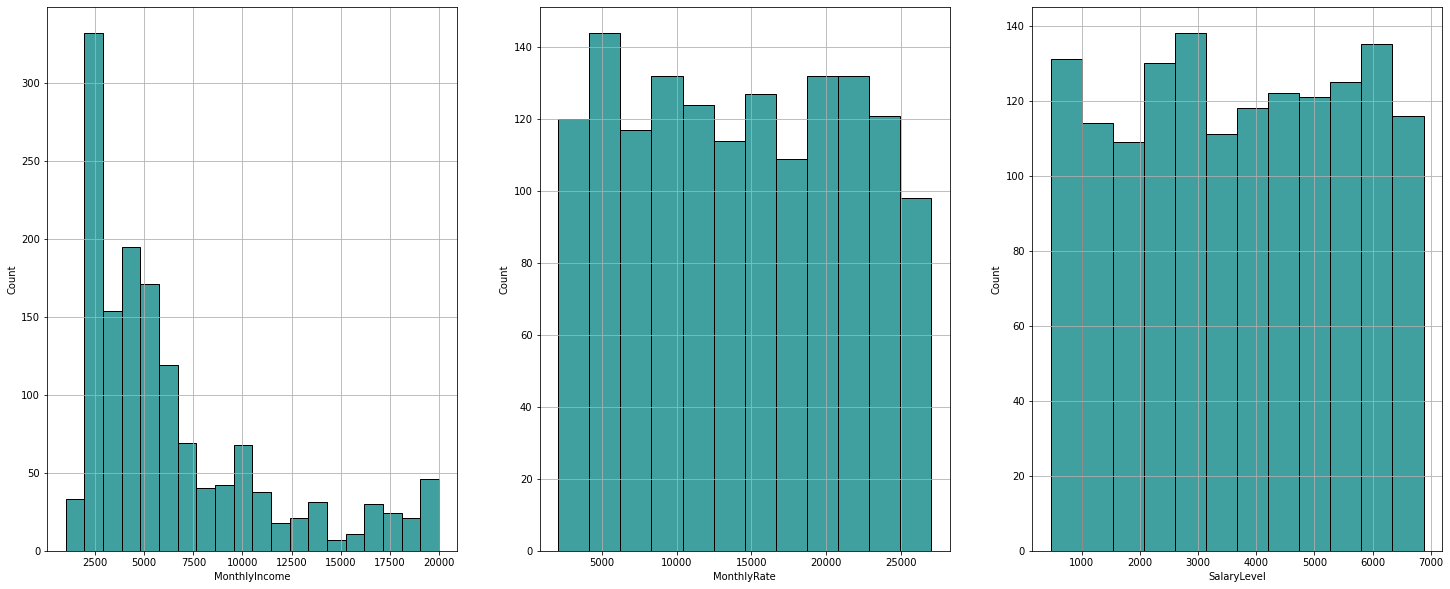

In [43]:
# need to change to get the best size for visualization
FIGSIZE = (25,10)

NROWS = 1
NCOLS = 3

plt.figure(figsize=FIGSIZE)

#
# here we do a loop over all columns and use subplot to arrange in a grid of plots
#
for i, col in enumerate(num_cols):
    plt.subplot(NROWS, NCOLS, i+1)
    # using Seaborn
    sns.histplot(data=df[col])
    plt.grid(True)
plt.show()

#### well, no one has a Normal distribution (Gaussian like)
* MonthlyRate and SalaryLevel are almost flat
* Monthly Income is decreasing

In [46]:
# compute stats for numerical

df2 = df[num_cols]

df2.describe().T

,count,mean,std,min,25%,50%,75%,max
MonthlyIncome,1470.0,6502.931293,4707.956783,1009.0,2911.0,4919.0,8379.0,19999.0
MonthlyRate,1470.0,14313.103401,7117.786044,2094.0,8047.0,14235.5,20461.5,26999.0
SalaryLevel,1470.0,3679.827211,1850.826241,466.0,2132.0,3678.0,5306.0,6874.0


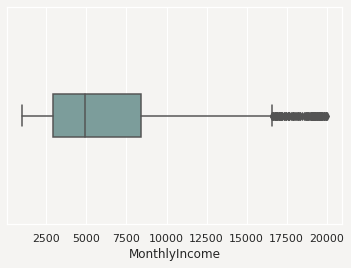

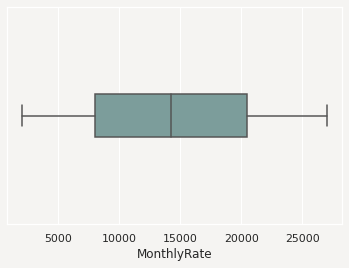

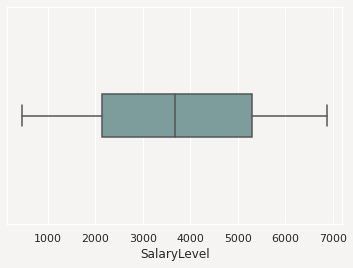

In [63]:
for i, col in enumerate(num_cols):
    ax = df2[col].ads.feature_plot()

In [53]:
# MonthlyIncome has some (possible) outliers

### Let's examine the TARGET

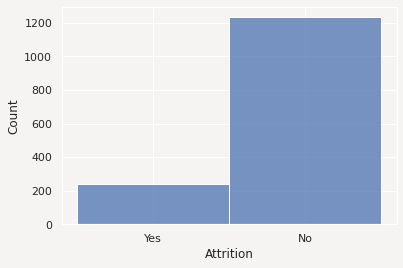

In [65]:
TARGET = 'Attrition'

sns.histplot(data=df[TARGET]);

#### We can see that the dataset is unbalanced: there are many more samples with Attrition = No

This is something that should be taken into account when we tune the ML models

### Compute correlations with TARGET

In [77]:
FEATURES = cat_cols + num_cols

# let's encode TARGET

df3 = df[FEATURES]

le = LabelEncoder()

target_values = df3[TARGET].values

target_values = le.fit_transform(target_values)

df3['Attrition_encoded'] = target_values

In [79]:
corr_matrix = df3.corr()

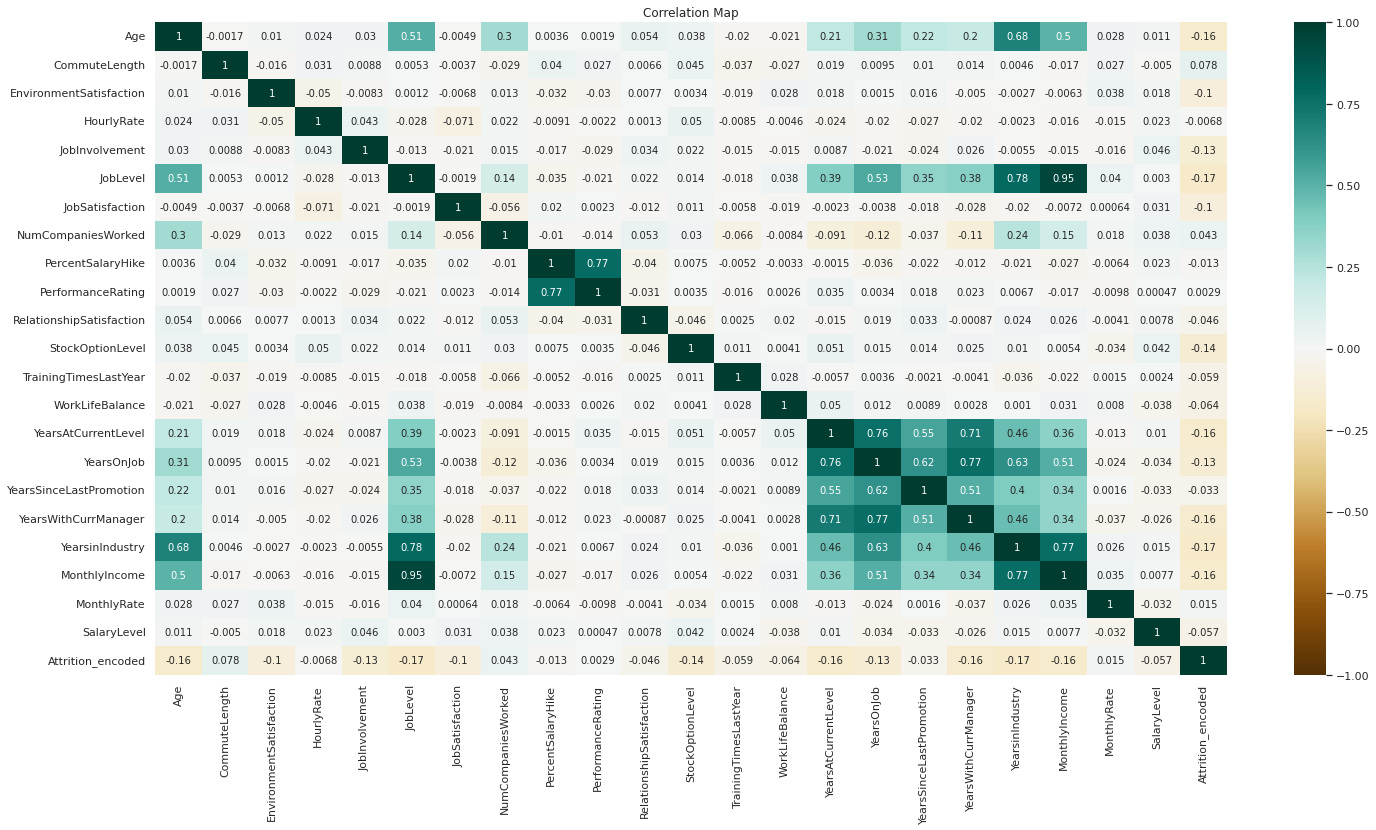

In [84]:
#
# Then we plot it as an HeatMap
#
FIGSIZE = (24, 12)

plt.figure(figsize=FIGSIZE)

# for the colormap, see: https://matplotlib.org/stable/tutorials/colors/colormaps.html
heatmap = sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Map', fontdict={'fontsize':12});

In [83]:
# we can see that there are many negative correlatuons (they make sense)
# in addition, we have several features strongly correlated. This could suggest dimensionality reduction in case of overfitting